In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('../Donem Projesi/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
my_classes = ['bird', 'cat','dog','elephant','horse']

../Donem Projesi/deneme1.ipynb
../Donem Projesi/.ipynb_checkpoints\deneme1-checkpoint.ipynb
../Donem Projesi/animals_sounds_yamnet\keras_metadata.pb
../Donem Projesi/animals_sounds_yamnet\saved_model.pb
../Donem Projesi/animals_sounds_yamnet\assets\yamnet_class_map.csv
../Donem Projesi/animals_sounds_yamnet\variables\variables.data-00000-of-00001
../Donem Projesi/animals_sounds_yamnet\variables\variables.index
../Donem Projesi/animal_sounds\birds\bird (1).wav
../Donem Projesi/animal_sounds\birds\bird (10).wav
../Donem Projesi/animal_sounds\birds\bird (100).wav
../Donem Projesi/animal_sounds\birds\bird (101).wav
../Donem Projesi/animal_sounds\birds\bird (102).wav
../Donem Projesi/animal_sounds\birds\bird (103).wav
../Donem Projesi/animal_sounds\birds\bird (104).wav
../Donem Projesi/animal_sounds\birds\bird (105).wav
../Donem Projesi/animal_sounds\birds\bird (106).wav
../Donem Projesi/animal_sounds\birds\bird (107).wav
../Donem Projesi/animal_sounds\birds\bird (108).wav
../Donem Projesi/

###  Ses dosyalarını diskten kolayca yükleyebilmek için ve eğiteceğimiz model için gerekli olan kütüphaneler

In [2]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio
import seaborn as sns
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

## YAMNet'i TensorFlow Hub'dan yükleme
### Ses dosyalarından yerleştirmeleri çıkarmak için Tensorflow Hub'dan önceden eğitilmiş bir YAMNet modeli kullanma


In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1' # TensorFlow Hub'dan bir model yüklemek basittir: 
yamnet_model = hub.load(yamnet_model_handle)            # modeli seçiyoruz ve URL'sini kopyalayın ve load işlevini kullanıyoruz.

### Ses dosyalarını yüklemek ve doğru örnekleme oranını sağlamak için fonksiyon

In [4]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### YAMNet'in tanıyabileceği sınıf adlarını yükleme ve belirli bir kısmını listeleme

In [5]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


###  Model eğitimi için gerekli olan ses dosyalarını diskten okuma ve tek bir sütunda birleştirme ve tür belirlemeye yardımcı olacak yeni bir sütun ekleme

In [6]:
bird_files = '../Donem Projesi/animal_sounds/birds/' +\
pd.DataFrame(os.listdir("../Donem Projesi/animal_sounds/birds/"),columns=["file_name"])
bird_labels = pd.DataFrame(np.asarray(np.zeros(len(bird_files))).astype(np.int32),columns=["label"])
cat_files = '../Donem Projesi/animal_sounds/cats/' +\
pd.DataFrame(os.listdir("../Donem Projesi/animal_sounds/cats/"),columns=["file_name"])
cat_labels = pd.DataFrame(np.asarray(np.ones(len(cat_files))).astype(np.int32),columns=["label"]) 
dog_files = '../Donem Projesi/animal_sounds/dogs/' +\
pd.DataFrame(os.listdir("../Donem Projesi/animal_sounds/dogs/"),columns=["file_name"])
list_of_dogs= []
for i in range (len(dog_files)):
    list_of_dogs.append(2)
dog_labels = pd.DataFrame(list_of_dogs,columns=["label"],dtype=np.int32 )
elephant_files = '../Donem Projesi/animal_sounds/elephants/' +\
pd.DataFrame(os.listdir("../Donem Projesi/animal_sounds/elephants/"),columns=["file_name"])
list_of_elephants= []
for i in range (len(elephant_files)):
    list_of_elephants.append(3)
elephant_labels = pd.DataFrame(list_of_elephants,columns=["label"],dtype=np.int32 )
horse_files = '../Donem Projesi/animal_sounds/horses/' +\
pd.DataFrame(os.listdir("../Donem Projesi/animal_sounds/horses/"),columns=["file_name"])
list_of_horses= []
for i in range (len(horse_files)):
    list_of_horses.append(4)
horse_labels = pd.DataFrame(list_of_horses,columns=["label"],dtype=np.int32 )
data=pd.concat([bird_files, cat_files, dog_files, elephant_files, horse_files]
               ,ignore_index=True).squeeze()
labels=pd.concat([bird_labels, cat_labels, dog_labels, elephant_labels, horse_labels]
                 ,ignore_index=True).squeeze()
complete=pd.concat([data,labels], axis=1)

In [7]:
#Sınıf ses sayıları kontrol
# 0 -> bird
# 1 -> cat
# 2 -> dog
# 3 -> elephant
# 4 -> horse

a =complete.label.value_counts()
print(a)

3    199
1    164
4    136
0    127
2    113
Name: label, dtype: int64


# Train-test Split

### Modelimiz 'load_wav_16k_mano' fonksiyonu ile uygulanacak model için WAV verilerini hazırlıyor. WAV verilerinden yerleştirmeleri çıkarırken bir şekil dizisi (N,1024) elde ediyoruz. Burada N sayısı, YAMNet modelinin bulduğu kare sayısıdır.
### Ve modelimiz her kareyi bir girdi olarak kullanacaktır.  Bu nedenle, satır başına bir çerçeve içeren yeni bir sütun oluşturmamız gerekir. Bu yeni satırları uygun şekilde yansıtmak için etiketleri ve fold sütununu da genişletmemiz gerekir. Genişletilmiş fold sütunu, orijinal değerleri korur. Çerçeveleri karıştıramazsınız çünkü bölmeleri gerçekleştirirken, farklı bölmelerde aynı sesin parçalarına sahip olabilirsiniz, bu da doğrulama ve test adımlarınızı daha az etkili hale getirir.


In [9]:
X=complete["file_name"].values
y=complete["label"].values

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.15, random_state=2, stratify=y)
trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.21, random_state=2, stratify=trainy)
    
train_0, train_1,train_2 = len(trainy[trainy==0]), len(trainy[trainy==1]), len(trainy[trainy==2])
train_3, train_4 = len(trainy[trainy==3]), len(trainy[trainy==4])

test_0, test_1,test_2 = len(testy[testy==0]), len(testy[testy==1]), len(testy[testy==2])
test_3, test_4 = len(testy[testy==3]), len(testy[testy==4])
                                                                        
val_0, val_1, val_2 = len(valy[valy==0]), len(valy[valy==1]), len(valy[valy==2])
val_3, val_4 = len(valy[valy==3]), len(valy[valy==4])  

                                                                        
print('>Train: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d' % (train_0, train_1, train_2, train_3, train_4))
print('>Test: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d' % (test_0, test_1, test_2, test_3, test_4))
print('>Val: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d' % (val_0, val_1, val_2, val_3, val_4))
                                                                        
                                                                        
folds=[]
for file in X:
    if file in testX:
        folds.append("testX")
    elif file in valX:
        folds.append("valX")
    else: folds.append("trainX")
        
        
fold_names = pd.DataFrame(folds,columns=["fold"]).squeeze()
complete=pd.concat([complete,fold_names], axis=1)
complete = shuffle(complete)
complete.head()

>Train: 0=85, 1=110, 2=76, 3=133, 4=92
>Test: 0=19, 1=25, 2=17, 3=30, 4=20
>Val: 0=23, 1=29, 2=20, 3=36, 4=24


,file_name,label,fold
137,../Donem Projesi/animal_sounds/cats/cat_109.wav,1,trainX
729,../Donem Projesi/animal_sounds/horses/horse (9...,4,valX
236,../Donem Projesi/animal_sounds/cats/cat_5.wav,1,trainX
668,../Donem Projesi/animal_sounds/horses/horse (3...,4,valX
330,../Donem Projesi/animal_sounds/dogs/dog_barkin...,2,valX


# Ses dosyalarını yükleme ve yerleştirmeleri alma

In [47]:
main_ds = tf.data.Dataset.from_tensor_slices((data, labels,folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [48]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

In [49]:
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [50]:
# gömme çıkarma modelini bir wav verisine uygular
def extract_embedding(wav_data, label, fold):
  
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding (gömme çıkarma)
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

# Verileri bölme


In [26]:
# veri setini train,validation ve teste bölmek için fold sütunundan yararlanma
# fold değerleri aynı orijinal wav dosyasındaki dosyaların aynı bölmede tutulacağı şekildedir.
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == "trainX")
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == "valX")
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == "testX")

# artık gerekli olmadığı için folds sütununu kaldıralım
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model Oluşturma
### Model oluşturmaya başlamak için Sequential Model yani Sıralı Model tanımlayalım --> bir gizli katman ve kuşları, kedileri, köpekleri, filleri ve atları tanımak için 5 çıktı

In [27]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 1,739,269
Trainable params: 1,739,269
Non-trainable params: 0
_________________________________________________________________


In [28]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=12,
                                            restore_best_weights=True)

In [29]:
history = my_model.fit(train_ds,
                       epochs=50,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/50
123/123 [==============================] - 26s 153ms/step - loss: 0.6257 - accuracy: 0.8649 - val_loss: 0.9799 - val_accuracy: 0.7077
Epoch 2/50
123/123 [==============================] - 2s 14ms/step - loss: 0.2768 - accuracy: 0.9252 - val_loss: 0.8677 - val_accuracy: 0.7378
Epoch 3/50
123/123 [==============================] - 2s 14ms/step - loss: 0.2129 - accuracy: 0.9430 - val_loss: 0.6723 - val_accuracy: 0.8064
Epoch 4/50
123/123 [==============================] - 2s 14ms/step - loss: 0.1337 - accuracy: 0.9623 - val_loss: 0.8455 - val_accuracy: 0.8008
Epoch 5/50
123/123 [==============================] - 2s 14ms/step - loss: 0.1355 - accuracy: 0.9613 - val_loss: 0.7401 - val_accuracy: 0.8195
Epoch 6/50
123/123 [==============================] - 2s 14ms/step - loss: 0.1195 - accuracy: 0.9720 - val_loss: 0.6711 - val_accuracy: 0.8242
Epoch 7/50
123/123 [==============================] - 2s 14ms/step - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.7901 - val_accuracy: 0.82

In [30]:
loss, accuracy = my_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

31/31 [==============================] - 0s 6ms/step - loss: 2.2355 - accuracy: 0.8784
Loss:  2.235492467880249
Accuracy:  0.8784194588661194


### Eğitim sırasında modelmiizin nasıl geliştiğini görmek için eğitim ve doğrulama kaybı eğrilerini kontrol etme.

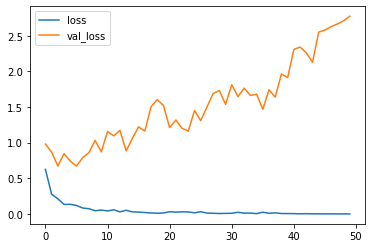

In [31]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Doğrudan bir WAV dosyasını girdi olarak alabilen bir modeli kaydetme
### Model, girdi olarak yerleştirmeleri aldığında çalışır. Gerçek bir durumda, ona ses verilerini doğrudan vermek istiyoruz. Bunu yapmak için, YAMNet'i yeni modelle, diğer uygulamalar için dışa aktarılabilecek tek bir modelde birleştireceğiz. Modelin sonucunu kullanmayı kolaylaştırmak için son katman bir reduce_mean yani azaltma ve ortalama işlemi olacaktır.

In [32]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


saved_model_path = './animals_sounds_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


#Load the saved model to verify that it works as expected.
reloaded_model = tf.saved_model.load(saved_model_path)

INFO:tensorflow:Assets written to: ./animals_sounds_yamnet\assets


INFO:tensorflow:Assets written to: ./animals_sounds_yamnet\assets


../Donem Projesi/animal_sounds/birds/bird (61).wav
Waveform values: [ 2.3483253e-08 -1.1317870e-07  2.7907853e-07 ... -1.3976282e-03
 -1.2619771e-03 -1.7866860e-03]


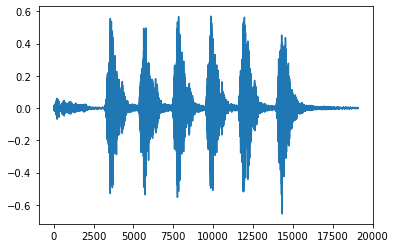

In [39]:
test_pd = complete.loc[complete['fold'] == "testX"] 
row = test_pd.sample(1)
filename = row['file_name'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [40]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {infered_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_infered_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Our model] The main sound is: {your_infered_class} ({your_top_score})')

[YAMNet] The main sound is: Bird (0.9909765124320984)
[Our model] The main sound is: bird (1.0)


## Hazırladığımız test setinin performansını belirleme

In [35]:
test_audio = []
test_labels = []

for _, row in test_pd.iterrows():
    test_audio.append(load_wav_16k_mono(row["file_name"]))
    test_labels.append(row['label'])
    

y_pred=[]
for test_sound in test_audio:
    y_pred.append(reloaded_model(test_sound))
y_pred = np.argmax(y_pred, axis=1)


y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 97%


# Display a confusion matrix
### Bir karışıklık matrisi, modelin test setindeki sınıfların her birinde ne kadar başarılı olduğunu görmek için yardımcı olur.

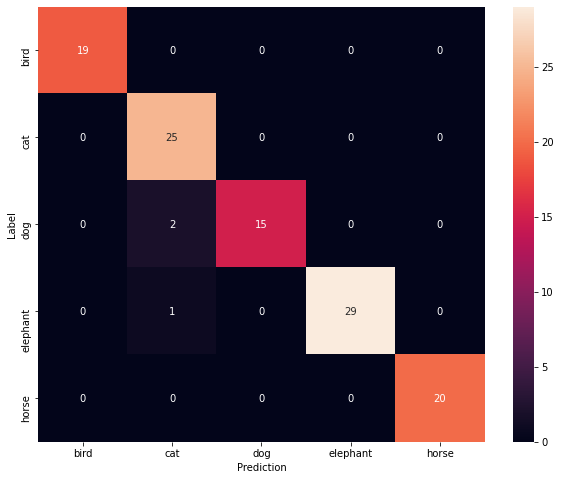

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=my_classes, yticklabels=my_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()